# 8. Calibration of double ended measurement with WLS and confidence intervals

A double-ended calibration is performed where the unknown parameters are estimated using fiber sections that have a reference temperature. The parameters are estimated with a weighted least squares optimization using Stokes and anti-Stokes measurements from all timesteps. Thus Stokes and anti-Stokes measurements with a large signal to noise ratio contribute more towards estimating the optimal parameter set. But an estimate of the noise variance is required.

Double-ended calibration requires a few steps. Please have a look at [1] for more information:
1. Read the raw data files loaded from your DTS machine
2. Define the reference sections: fiber sections that have a known temperature.
3. Estimate the variance of the noise in the Stokes and anti-Stokes measurements
4. Perform the parameter search and compute the temperature along the entire fiber.
5. Compute the confidence intervals for the temperature

[1]: des Tombe, B., Schilperoort, B., & Bakker, M. (2020). Estimation of Temperature and Associated Uncertainty from Fiber-Optic Raman-Spectrum Distributed Temperature Sensing. Sensors, 20(8), 2235. https://doi.org/10.3390/s20082235

In [1]:
import os
import warnings

warnings.simplefilter('ignore')  # Hide warnings to avoid clutter in the notebook


from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 100))  # only calibrate parts of the fiber
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }
ds.sections = sections

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended
Reading the data from disk


First calculate the variance in the measured Stokes and anti-Stokes signals, in the forward and backward direction.

The Stokes and anti-Stokes signals should follow a smooth decaying exponential. This function fits a decaying exponential to each reference section for each time step. The variance of the residuals between the measured Stokes and anti-Stokes signals and the fitted signals is used as an estimate of the variance in measured signals.

In [3]:
st_var, resid = ds.variance_stokes_constant(st_label='st')
ast_var, _ = ds.variance_stokes_constant(st_label='ast')
rst_var, _ = ds.variance_stokes_constant(st_label='rst')
rast_var, _ = ds.variance_stokes_constant(st_label='rast')

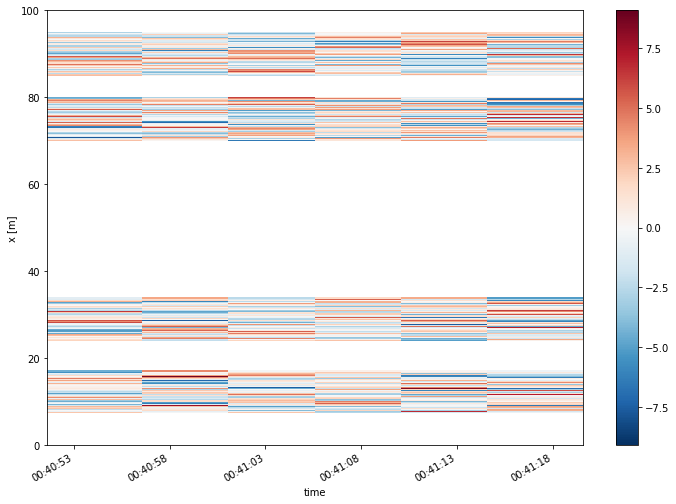

In [4]:
resid.plot(figsize=(12, 8));

We calibrate the measurement with a single method call. The labels refer to the keys in the DataStore object containing the Stokes, anti-Stokes, reverse Stokes and reverse anti-Stokes. The variance in those measurements were calculated in the previous step. We use a sparse solver because it saves us memory.

In [5]:
ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

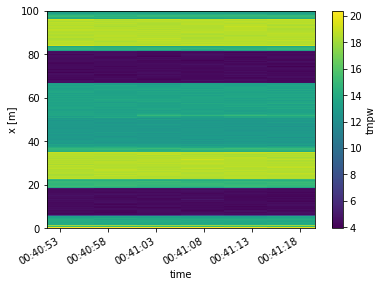

In [6]:
ds.tmpw.plot()

## Confidence intervals

With another method call we estimate the confidence intervals. If the method is `wls` and confidence intervals are passed to `conf_ints`, confidence intervals calculated. As weigths are correctly passed to the least squares procedure, the covariance matrix can be used as an estimator for the uncertainty in the parameters. This matrix holds the covariances between all the parameters. A large parameter set is generated from this matrix as part of the Monte Carlo routine, assuming the parameter space is normally distributed with their mean at the best estimate of the least squares procedure.

The large parameter set is used to calculate a large set of temperatures. By using `percentiles` or `quantile` the 95% confidence interval of the calibrated temperature between 2.5% and 97.5% are calculated.

The confidence intervals differ per time step. If you would like to calculate confidence intervals temporal averages or averages of fiber sections see notebook 16.

In [7]:
ds.conf_int_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    conf_ints=[2.5, 50., 97.5],
    mc_sample_size=500)  # <- choose a much larger sample size)

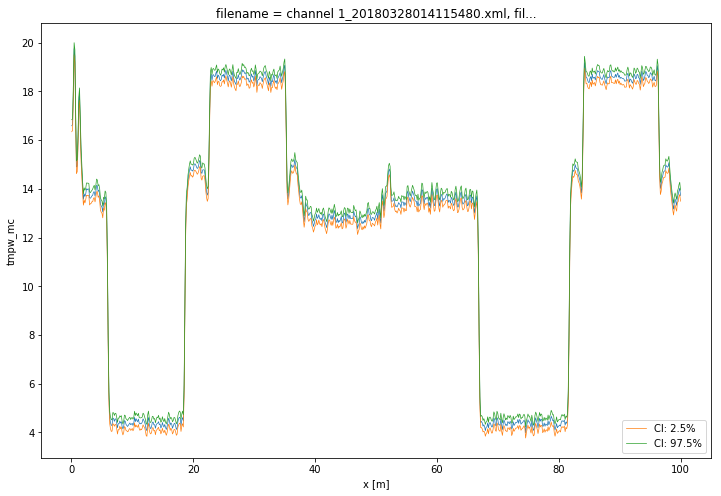

In [8]:
ds1 = ds.isel(time=-1)  # take only the first timestep
ds1.tmpw.plot(linewidth=0.7, figsize=(12, 8))
ds1.tmpw_mc.isel(CI=0).plot(linewidth=0.7, label='CI: 2.5%')
ds1.tmpw_mc.isel(CI=2).plot(linewidth=0.7, label='CI: 97.5%')
plt.legend();

The DataArrays `tmpf_mc` and `tmpb_mc` and the dimension `CI` are added. `MC` stands for monte carlo and the `CI` dimension holds the confidence interval 'coordinates'.

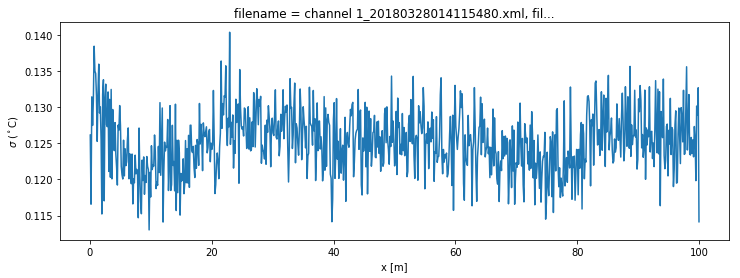

In [9]:
(ds1.tmpw_mc_var**0.5).plot(figsize=(12, 4));
plt.ylabel('$\sigma$ ($^\circ$C)');